In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point, LineString, Polygon
import ast

def flexible_matching(key, coord, threshold=0.01):
    # Check if the absolute difference between the coordinate and the key is within the threshold
    if abs(key - coord) < threshold:
        return True
    else:
        return False
    
def extract_stops(temp_rail, temp_stations):
    if(len(temp_rail) > 0):
        cities = []
        for n in np.arange(0, len(temp_rail) - 1):
            stop_coordinates = list(temp_rail['geometry'].iloc[n].coords)
            for item in stop_coordinates:
                for n in np.arange(0, len(temp_stations) - 1):
                    lat = temp_stations['latitude'].iloc[n]
                    lon = temp_stations['longitude'].iloc[n]
                    if(flexible_matching(item[0], lon) and flexible_matching(item[1], lat)):
                        cities.append([temp_stations['node_label'].iloc[n]])
        cities = np.unique(cities)
        # Convert the numpy array back to a list to have commas separators between the elements
        cities_list = cities.tolist()
        return (cities_list)
    else:
        print("Empty Rail")

def random_color():
    return (random.random(), random.random(), random.random())

ICC_labels = {'GE':'Georgia',
            'IT': 'Italy',
            "FR": "France",
            "LT": "Lithuania",
            "SK": "Slovakia",
            "PT": "Portugal",
            "ES": "Spain",
            "EE": "Estonia",
            "RS": "Serbia",
            "HU": "Hungary",
            "IE": "Ireland",
            "PL": "Poland",
            "AT": "Austria",
            "LU": "Luxemburg",
            "CH": "Switzerland",
            "BE": "Belgium",
            "CZ": "Czech Republich",
            "NL": "Netherlands",
            "GR": "Greece",
            "GB": "Great Britain",
            "RO": "Romania",
            "ND": "Northen Ireland",
            "MD": "Moldova",
            "DK": "Denmark",
            "NO": "Norwey",
            "SE": "Sweden",
            "FI": "Finland",
            "LV": "Latvia",
            "DE": "Germany",
            "SI": "Slovenia",
            "HR": "Croatia",
            "BG": "Bulgaria",
            "UA": "Ukraine",
            "MK": "Macedonia"}

keys_list = sorted(list(ICC_labels.keys()))
start_index = keys_list.index('IT')
keys_sublist = keys_list[start_index:]

# European Railway Network (IT, ... UA)

 The output consists of two files for each country: 
 
 - one for nodes (nodeID,nodeLabel,latitude,longitude,country_name,country_ISO3)
 - one for edges list (nodeID_from,nodeID_to).

# Get nodes data

Imput files:

- RailrdC.shp
- RailrdC.shx
- RailrdC.dbf

Careful! These three files are mandatory. If any of these files are missing, you cannot open the .shp file.

Output files: 'ICC_nodes.csv' for each country

In [19]:
stations = gpd.read_file("RailrdC.shp")

### Data features: 

core attributes

ICC = The ISO 3166-1 2-char Country Code defining the country dataset to which the feature is belonging. In case of more than one country, the codes are delimited by # and set in alphabetical order. In case of no country responsible (terra nullius), the ICC code is set to “XX”.

specific attributes

NAMA1 = name in first national language, written in international alphabet

- Actual value
- <UNK> unknown
- <N_A>

NLN1 = language code (e.s. FRE for French language)

TFC = Trasportation Facility Type 

- 0 unknown
- 15 railway station, 
- 31 joint railway station. A "joint" railway station is simply a station which operates under control of more than one company. 
- 32 halt. A "halt" is a small stop station. 
- 33 marshmalling yard. A "marshalling yard" is "stazione di smistamento" i.e. a place where vagons are put together into trains. 
- 34 intermodal rail transport terminal. An "intermodal rail terminal" is a terminal used for mixed-transport of freight or passengers. 

TUC = Transportation Use Category

- 0 unknown
- 25 cargo/freight
- 26 passenger
- 45 general
- 997 unpopulated

RStationID = unique identifier of the station

Now i will create a dictionary for the correspondeces between ICC codes and actual country names, and add a new column containing country names to the 'stations' GeoDataFrame. To get the codes/names information, refer to DOCUMENTS/EGM_2019_UserGuide.pdf (Annex C )

In [20]:
columns_to_extract = ['ICC', 'TFC', 'NAMA1', 'RStationID', 'TUC']
stations = gpd.GeoDataFrame(stations[columns_to_extract], geometry=stations.geometry)
stations['Country Name'] = stations['ICC'].map(ICC_labels)

### Preliminary scatterplots
Here I make scatterplots of the data, just to have a look at the spacial distribution and category. Color distinguishes among categories (Use and Facility).

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_964/4122731882.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_tfc = plt.cm.get_cmap('viridis', len(unique_tfc))
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_964/4122731882.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_tuc = plt.cm.get_cmap('viridis', len(unique_tuc))


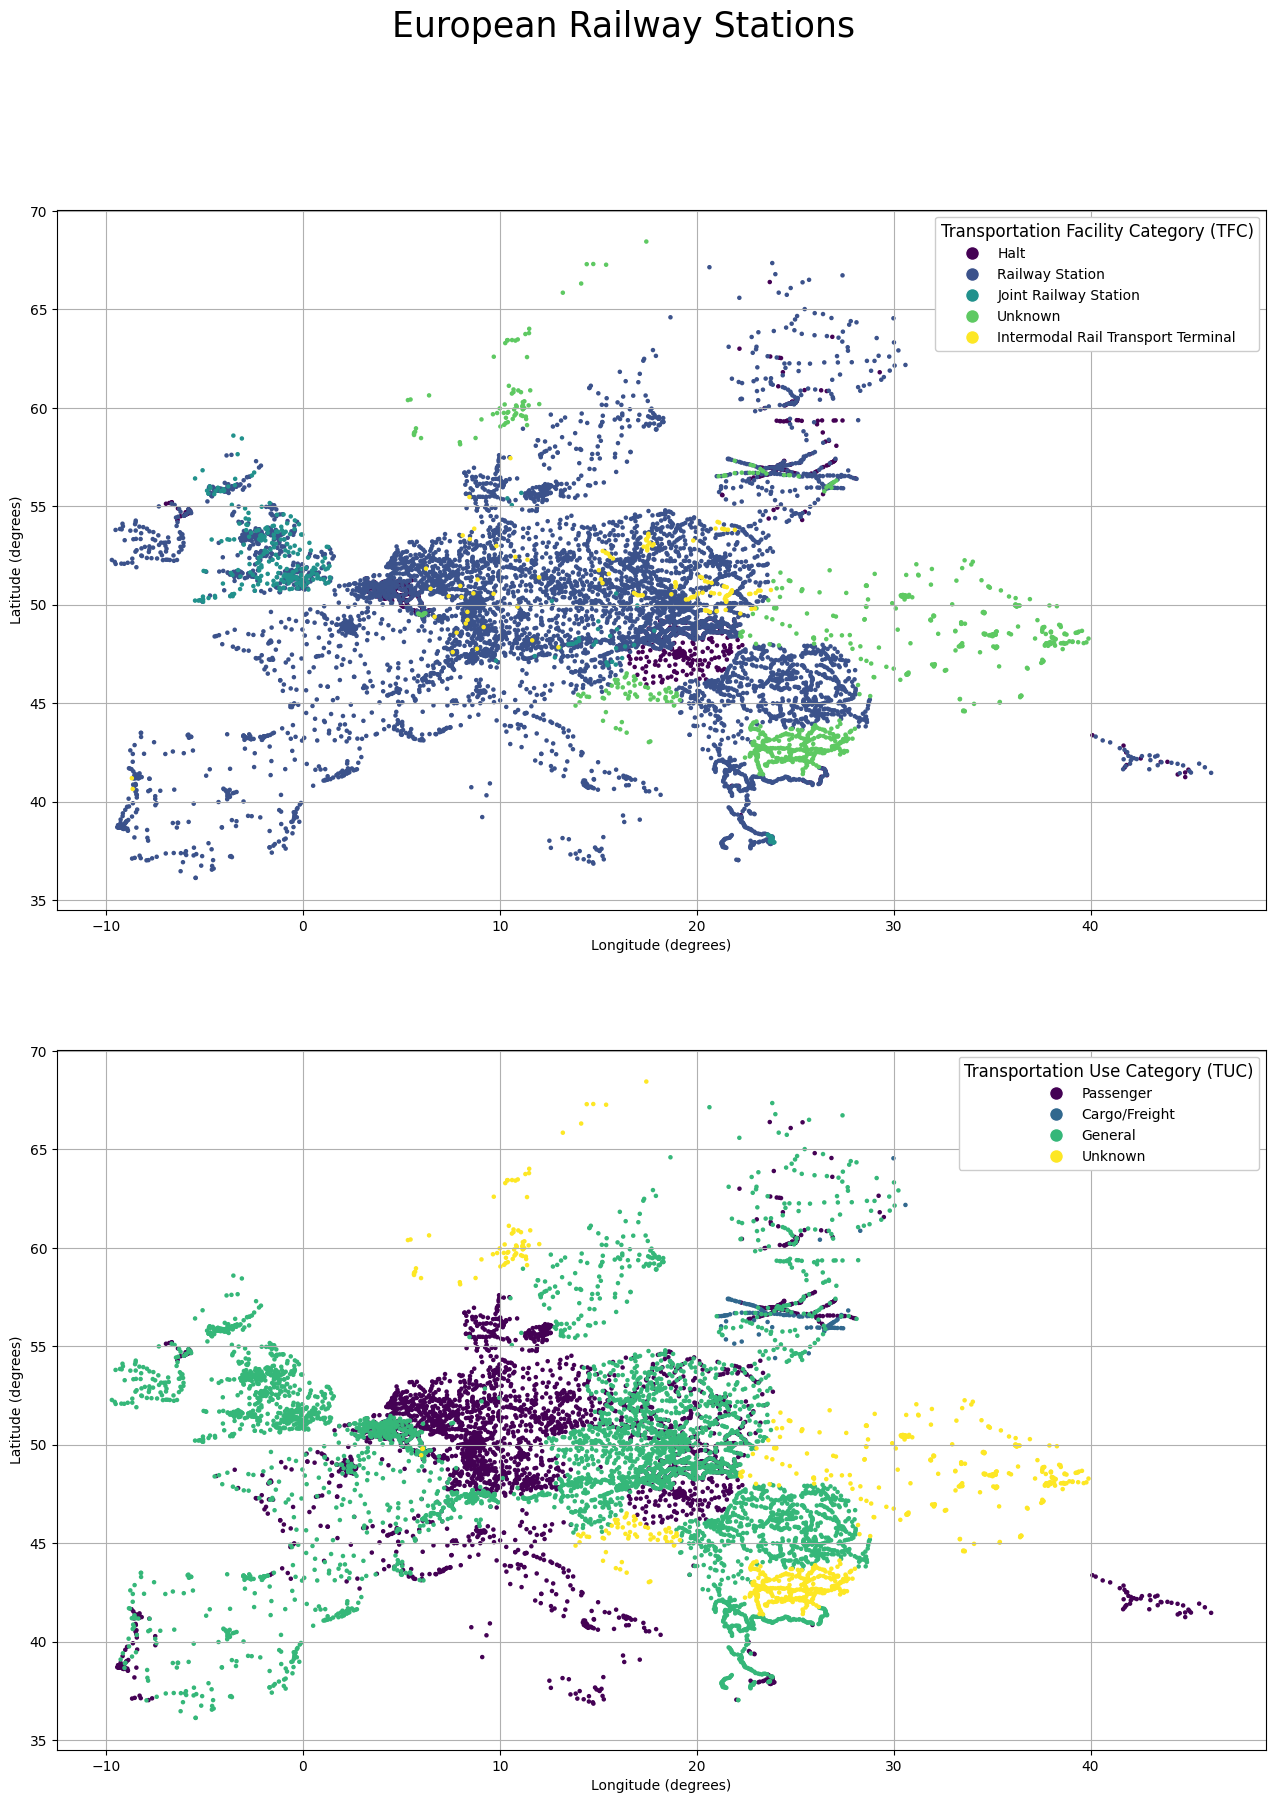

In [6]:
gdf = stations.copy()

tfc_labels = {0: 'Unknown', 15: 'Railway Station', 31: 'Joint Railway Station', 32: 'Halt', 33: "Marshalling Yard", 34: "Intermodal Rail Transport Terminal"}
tuc_labels = {0: 'Unknown', 25: 'Cargo/Freight', 26: 'Passenger', 45: 'General', 997: "Unpopulated"}

gdf['TFC_label'] = gdf['TFC'].map(tfc_labels)
gdf['TUC_label'] = gdf['TUC'].map(tuc_labels)

unique_tfc = gdf['TFC'].unique()
colors_tfc = plt.cm.get_cmap('viridis', len(unique_tfc))
color_map_tfc = {tfc: colors_tfc(i) for i, tfc in enumerate(unique_tfc)}
gdf['color_tfc'] = gdf['TFC'].apply(lambda x: color_map_tfc[x])

unique_tuc = gdf['TUC'].unique()
colors_tuc = plt.cm.get_cmap('viridis', len(unique_tuc))
color_map_tuc = {j: colors_tuc(i) for i, j in enumerate(unique_tuc)}
gdf['color_tuc'] = gdf['TUC'].apply(lambda x: color_map_tuc[x])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20))

# TFC plot
for tfc in unique_tfc:
    subset = gdf[gdf['TFC'] == tfc]
    subset.plot(ax=ax1, color=subset['color_tfc'].tolist(), markersize=5, label = tfc_labels[tfc])
handles_tfc = [plt.Line2D([0], [0], marker='o', color='w', label=tfc_labels[tfc], markersize=10, markerfacecolor=color_map_tfc[tfc]) for tfc in unique_tfc]
ax1.legend(handles=handles_tfc, title='Transportation Facility Category (TFC)', title_fontsize = 12,  loc = 1, framealpha = 1)
ax1.set_xlabel("Longitude (degrees)")
ax1.set_ylabel("Latitude (degrees)")
ax1.grid()

# TUC plot
for i in unique_tuc:
    subset = gdf[gdf['TUC'] == i]
    subset.plot(ax=ax2, color=subset['color_tuc'].tolist(), markersize=5, label = tuc_labels[i])
handles_tuc = [plt.Line2D([0], [0], marker='o', color='w', label=tuc_labels[i], markersize=10, markerfacecolor=color_map_tuc[i]) for i in unique_tuc]
ax2.legend(handles=handles_tuc, title='Transportation Use Category (TUC)', title_fontsize = 12,  loc = 1, framealpha = 1)
ax2.set_xlabel("Longitude (degrees)")
ax2.set_ylabel("Latitude (degrees)")
ax2.grid()

plt.suptitle("European Railway Stations", fontsize = 25)
# Show plot
plt.savefig("stations_scatterplot.pdf")

Let's now have a closer look at Italy. I want to see which stations are included in this dataset, since it seems to me that many small ones are missing from the map.

number of rail stations in Italy=  206


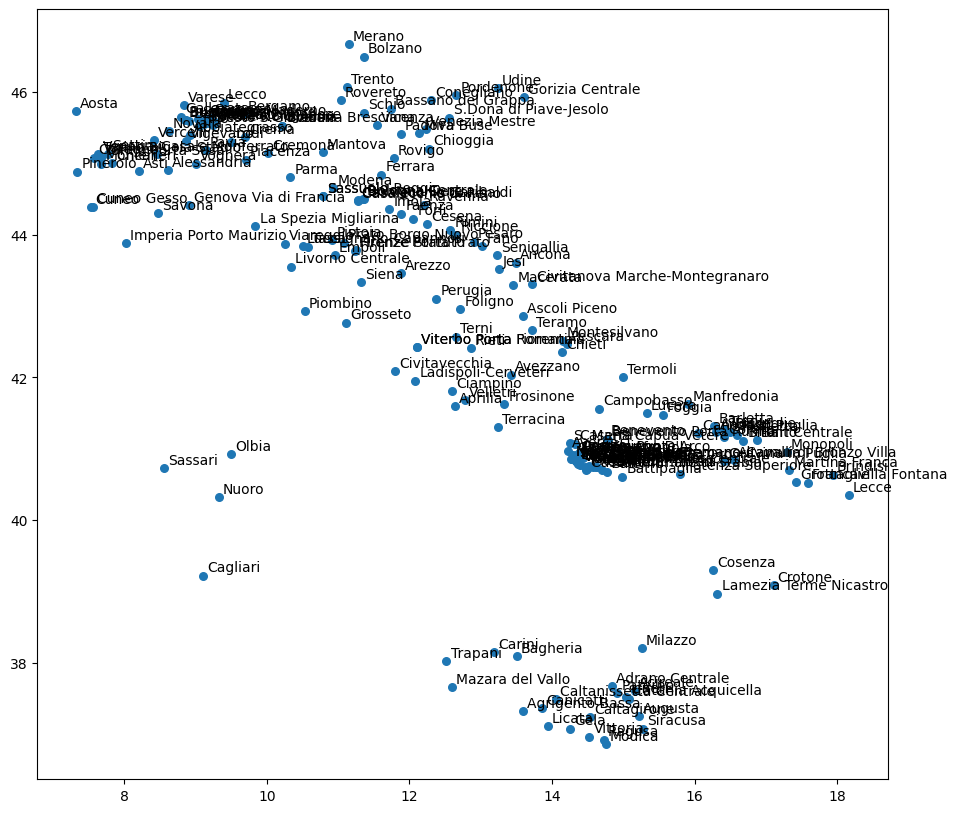

In [7]:
gdf = stations[stations["Country Name"] == "Italy"]
print("number of rail stations in Italy= ", len(gdf))

fig, ax = plt.subplots(1,1, figsize = (20, 10))

gdf.plot(ax=ax, markersize=30)
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['NAMA1']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", rotation = 0)

Many stations are indeed missing! Trieste, Petacciato Marina...

### Store data in .csv files for each country

- I create one file for whole EU ("whole_EU_stations.csv") and separate files for each country from IT to UA
- In each file the nodes are assigned indices starting from 1. 

- The columns are ('node_label', 'latitude', 'longitude', 'country_name', 'country_IS03')

- In the whole EU file, nodes are ordered alphabetically: first, for contry code and second, for station name 'NAMA1'. 

- In the separate country files, nodes are ordered alphabetically for station name 'NAMA1'.

In [21]:
stations = stations.sort_values(by=['ICC', 'NAMA1'])
stations = stations.reset_index(drop=True)
stations['lat'] = stations.geometry.y
stations['lon'] = stations.geometry.x
stations = stations.drop(columns= ['geometry', 'RStationID', 'TFC', 'TUC'])
stations = stations.rename(columns={'ICC': 'country_IS03', 'NAMA1' : 'node_label', 'lat': 'latitude', 'lon': 'longitude', 'Country Name': 'country_name'})
# Change column order
stations = stations[['node_label', 'latitude', 'longitude', 'country_name', 'country_IS03']]

In [7]:
# .csv file for the whole Europe
index_list = np.arange(1, len(stations)+1)
stations.insert(0, 'node_ID', index_list)
stations.to_csv("whole_EU_stations.csv", index = False )

# .csv files for each european country IT - UA
keys_list = sorted(list(ICC_labels.keys()))
start_index = keys_list.index('IT')
keys_sublist = keys_list[start_index:]

stations = stations.drop( columns= ['node_ID'])

for country_code in keys_sublist:
    subdataframe = stations[stations["country_IS03"] == country_code].copy()
    index_list = np.arange(1, len(subdataframe) + 1)
    subdataframe.insert(0, 'node_ID', index_list)
    path = f"{country_code}_nodes.csv"
    subdataframe.to_csv(path, index = False)

# Get edges data

EXS = existence category

- 0 unknown
- 5 under construction
- 6 abandoned
- 28 operational

NAMA1 = name in first national language

RSD = railroad speed class 

- 0 = unknown
- 1 = conventional
- 2 = upgraded high speed
- 3 = dedicated high speed
- 997 = unpopulated

TUC = transportation use category 

- 0 = unknown
- 25 = cargo/freight
- 26 = passenger
- 45 = general

In [22]:
rails = gpd.read_file("RailrdL.shp")
#print(rails.columns)
columns_to_extract = ['ICC', 'EXS', 'NAMA1', 'RSD', 'TUC', 'geometry']
rails = gpd.GeoDataFrame(rails[columns_to_extract], geometry=rails.geometry)
rails['country_name'] = rails['ICC'].map(ICC_labels)

### Scatterplot of rails
As before, just to see by eye how many are abandoned, under construction and operative (EXS), And how may are for passengers and/or freigth (TUC).

Note: I noticed there are some invalid values in the TUC and EXS columns. Luckily they are just a few. I need to add a key to my dictionaries tuc_labels and exs_labels because otherwise it won't plot. Next, I will discard those entries for the graph.

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_654/3369723954.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_tuc = plt.cm.get_cmap('viridis', len(unique_tuc))
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_654/3369723954.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_exs = plt.cm.get_cmap('viridis', len(unique_exs))


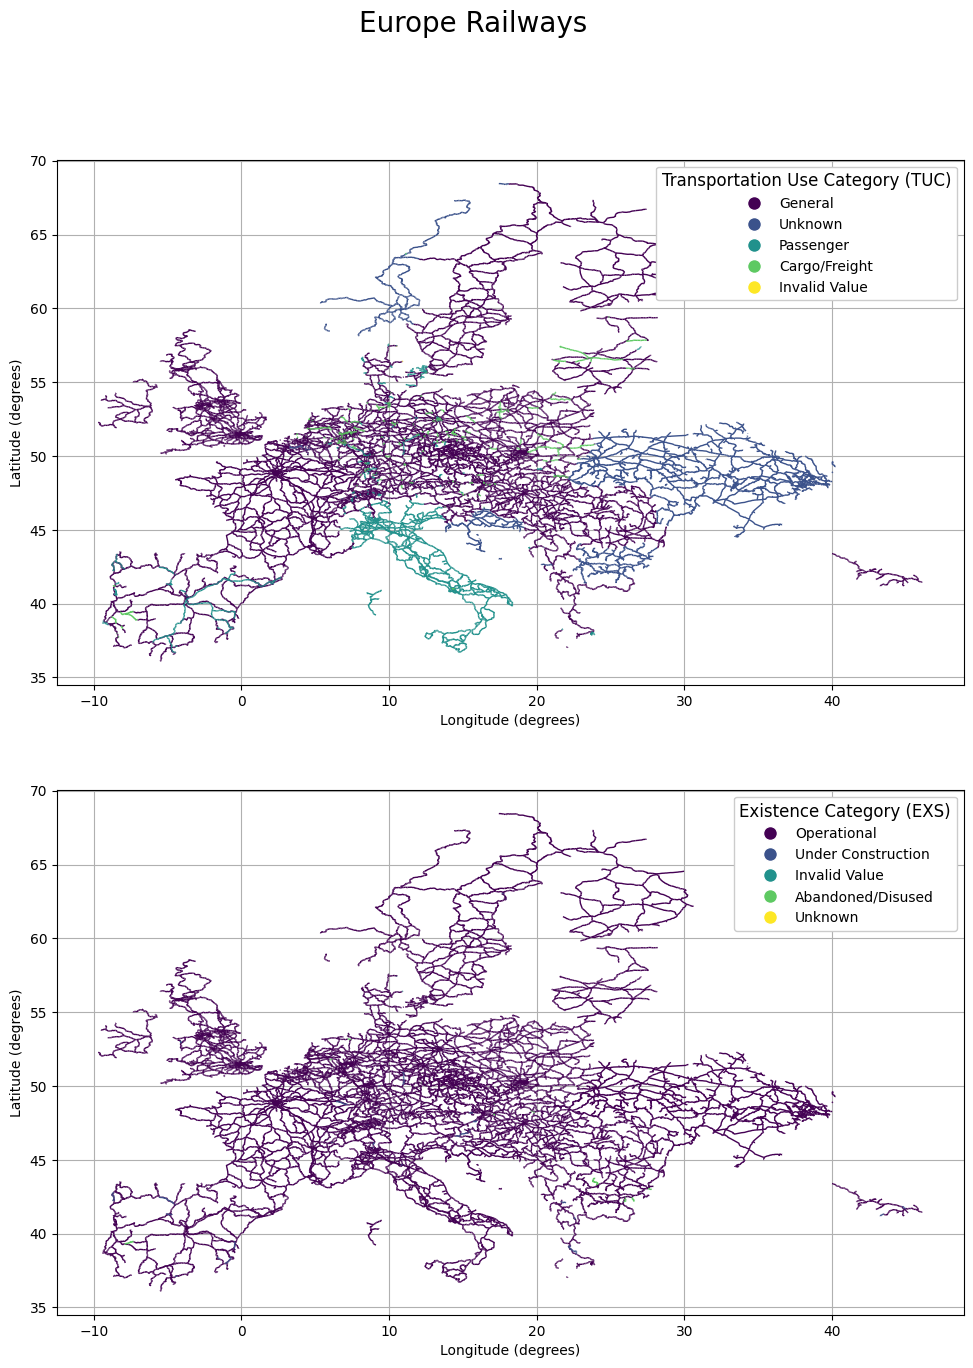

In [93]:
gdf = rails.copy()

tuc_labels = {0: 'Unknown', 25: 'Cargo/Freight', 26: 'Passenger', 45: 'General', -32768 : 'Invalid Value'}
exs_labels = {0: 'Unknown', 5: 'Under Construction', 6: 'Abandoned/Disused', 28: 'Operational', -32768 : 'Invalid Value'}

gdf['TUC_label'] = gdf['TUC'].map(tuc_labels)
gdf['EXS_label'] = gdf['EXS'].map(exs_labels)

unique_tuc = gdf['TUC'].unique()
colors_tuc = plt.cm.get_cmap('viridis', len(unique_tuc))

color_map_tuc = {j: colors_tuc(i) for i, j in enumerate(unique_tuc)} #enumerate(x) = (0, x[0]), (1, x[1]), ...
gdf['color_tuc'] = gdf['TUC'].apply(lambda x: color_map_tuc[x])

unique_exs = gdf['EXS'].unique()
colors_exs = plt.cm.get_cmap('viridis', len(unique_exs))
color_map_exs = {j: colors_exs(i) for i, j in enumerate(unique_exs)}
gdf['color_exs'] = gdf['EXS'].apply(lambda x: color_map_exs[x])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 15))

# TUC plot
for i in unique_tuc:
    subset = gdf[gdf['TUC'] == i]
    subset.plot(ax=ax1, color=subset['color_tuc'].tolist(), linewidth = 1, label = tuc_labels[i])
handles_tuc = [plt.Line2D([0], [0], marker='o', color='w', label=tuc_labels[j], markersize = 10, markerfacecolor=color_map_tuc[j]) for j in unique_tuc]
ax1.legend(handles=handles_tuc, title='Transportation Use Category (TUC)', title_fontsize = 12,  loc = 1, framealpha = 1)
ax1.set_xlabel("Longitude (degrees)")
ax1.set_ylabel("Latitude (degrees)")
ax1.grid()

# EXS plot
for i in unique_exs:
    subset = gdf[gdf['EXS'] == i]
    subset.plot(ax=ax2, color=subset['color_exs'].tolist(), linewidth = 1, label = exs_labels[i])
handles_exs = [plt.Line2D([0], [0], marker='o', color='w', label=exs_labels[j], markersize = 10, markerfacecolor=color_map_exs[j]) for j in unique_exs]
ax2.legend(handles=handles_exs, title='Existence Category (EXS)', title_fontsize = 12,  loc = 1, framealpha = 1)
ax2.set_xlabel("Longitude (degrees)")
ax2.set_ylabel("Latitude (degrees)")
ax2.grid()

plt.suptitle("Europe Railways", fontsize = 20)
plt.savefig("rails_scatterplot.pdf");

Now let's discard the invalid entries. We keep only operational railways (EXS = 28)

In [23]:
rails = rails[rails['EXS'] == 28]

### Pipeline method definition for extracting the edges

Imput: 'rails' geopanda dataframe, 'stations' geopanda dataframe

Outputs: 

- 'ICC_rails.csv' (railway_name, railway_stops_list)
- 'ICC_edges.csv' (node_from, node_to)

for each country IT-UA and whole EU


The information about railways is encoded in 'LineString' objects. A LINESTRING object consists of multiple points connected by straight segments.

The demanding part of the task will be to extract edges from the LINESTRING objects. I will not only need the extremas, but also the intermediate points which likely correspond to minor railway stations (halts). 

Let's start from a few rails in Italy just to see if the method works. Then we will do it over all europe railways.

number of railway stations =  206
real railway number 310
number of different linestring objects 4371
rail names=  ['Ancona-Lecce', 'Foggia-Manfredonia', 'Macomer-Nuoro', 'Chivasso-Ivrea-Aosta', 'Teramo-Giulianova', 'Chilivani-Olbia', 'Cagliari-Sassari', 'Aosta-Pont Saint Martin', 'Bologna-Verona', 'Messina-Palermo']


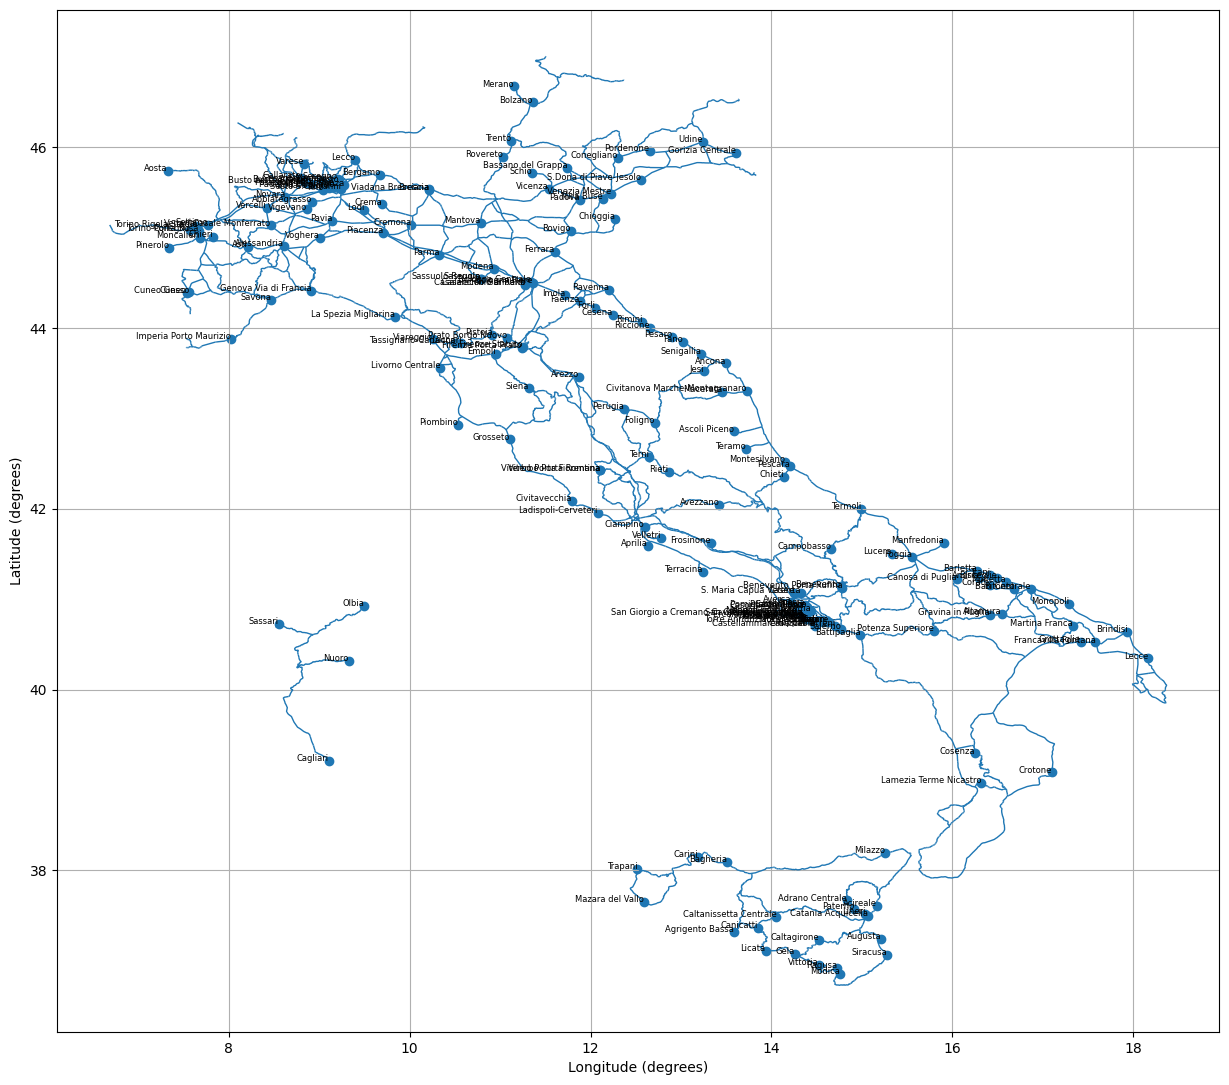

In [27]:
italy_stations = pd.read_csv('IT_nodes.csv')
italy_rails = rails[rails['ICC'] == 'IT'].copy()
nomi = italy_rails['NAMA1'].unique()
nomi_list = nomi.tolist() # to have comma separators
print("number of railway stations = ", len(italy_stations))
print("real railway number",len(nomi_list))
print("number of different linestring objects", len(italy_rails))
print("rail names= ", nomi_list[0:10])

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

italy_rails.plot(ax=ax,  linewidth = 1)
ax.scatter(italy_stations['longitude'], italy_stations['latitude'], marker = "o")
for i, row in italy_stations.iterrows():
    ax.text(row['longitude'], row['latitude'], row['node_label'], fontsize=6, ha='right')

ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
ax.grid()
plt.savefig("italy.pdf", dpi = 300 )


slices number = 70
stops of ancona lecce = ['Ancona', 'Bari Centrale', 'Barletta', 'Bisceglie', 'Brindisi', 'Civitanova Marche-Montegranaro', 'Foggia', 'Lecce', 'Molfetta', 'Monopoli', 'Montesilvano', 'Pescara', 'Termoli', 'Trani']
14


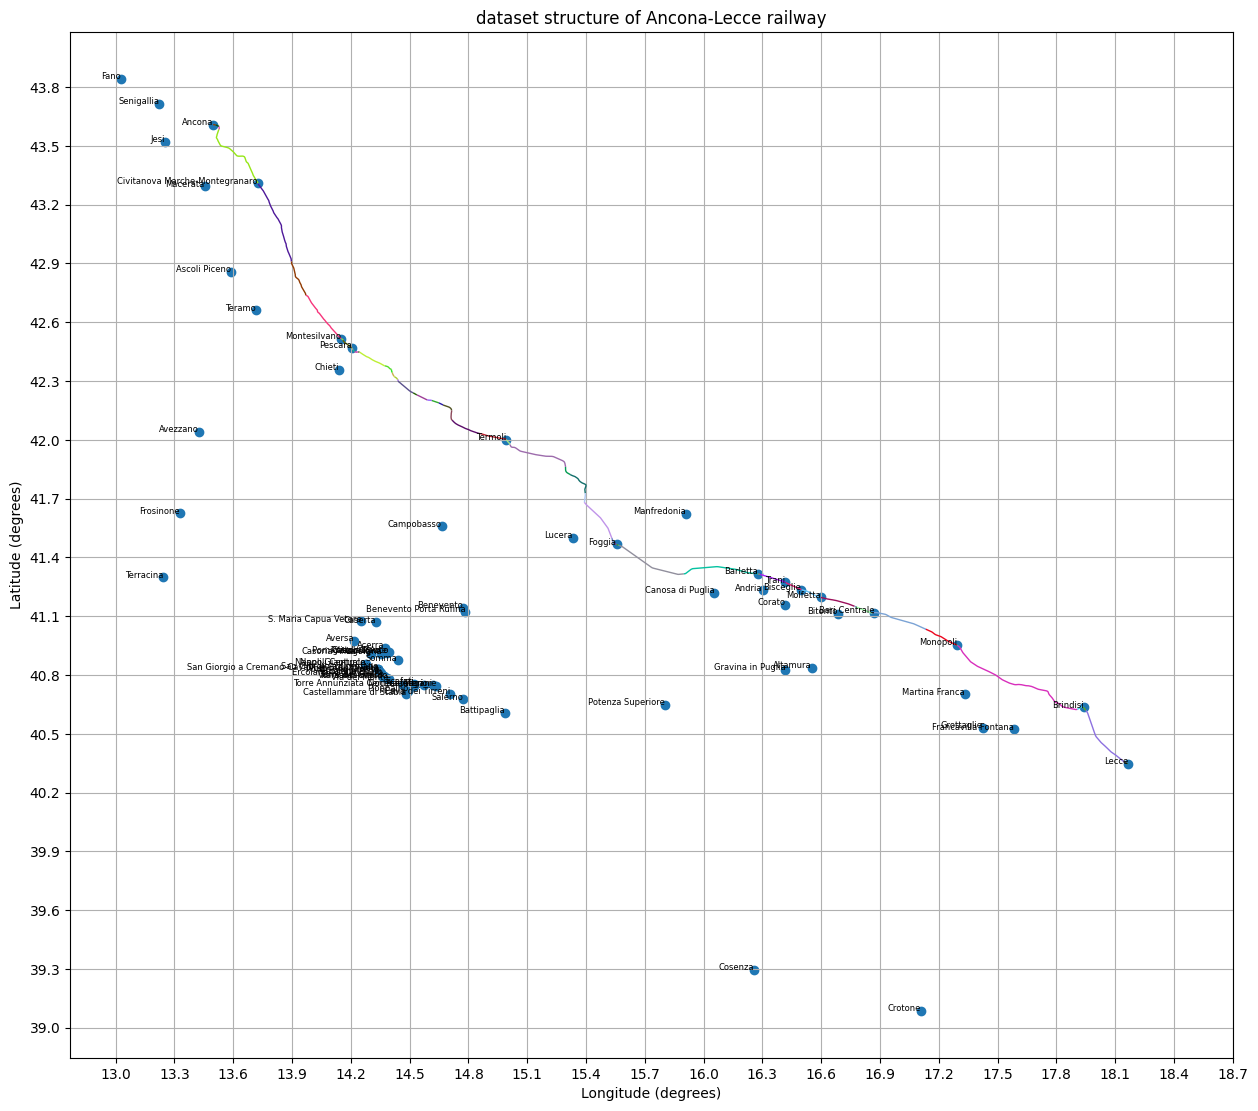

In [25]:
temp_rail = italy_rails[italy_rails['NAMA1'] == 'Ancona-Lecce'].copy()
print("slices number =", len(temp_rail))
temp_stations = italy_stations[(italy_stations['longitude'] > 13) & (italy_stations['longitude'] < 19)]
temp_stations = temp_stations[(temp_stations['latitude'] > 39) & (temp_stations['latitude'] < 44)]

cities = extract_stops(temp_rail, italy_stations)      
print("stops of ancona lecce =", cities)
print(len(cities))

fig, ax = plt.subplots(figsize=(15, 15))
random_color_vec = [random_color() for i in np.arange(0, len(temp_rail))]
temp_rail.plot(ax=ax, color = random_color_vec, linewidth = 1)
ax.scatter(temp_stations['longitude'], temp_stations['latitude'], marker = "o")
for i, row in temp_stations.iterrows():
    ax.text(row['longitude'], row['latitude'], row['node_label'], fontsize=6, ha='right')
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
ax.set_xticks(np.arange(13, 19, 0.3))  # Set x-ticks every 0.5 units
ax.set_yticks(np.arange(39, 44, 0.3))  # Set y-ticks every 0.1 units
ax.grid(which='both')
ax.set_title("dataset structure of Ancona-Lecce railway")
plt.savefig("ancona_lecce.pdf")
plt.show()

The method work, but this was an "easy" railway, since nodes are not dense. Let's try with a more densely populated area like Napoli

In [11]:
minimum_latitude = 40.6
maximum_latitude = 41

minimum_longitude = 14.2
maximum_longitude = 14.8

columns = ['ICC', 'EXS', 'NAMA1', 'RSD', 'TUC', 'geometry', 'country_name']  
geometry_type = 'LineString'  
combined_gdf = gpd.GeoDataFrame(columns=columns, geometry= 'geometry')

# select all rails with coordinates that fall in this rectangular area
for i in np.arange(0, len(italy_rails), 1):
    stop_coordinates = list(italy_rails['geometry'].iloc[i].coords)
    stop_longitudes = [x[0] for x in stop_coordinates]
    stop_latitudes = [x[1] for x in stop_coordinates]
    if (any(minimum_longitude < element < maximum_longitude for element in stop_longitudes) & any(minimum_latitude < element < maximum_latitude for element in stop_latitudes)):
        combined_gdf = gpd.GeoDataFrame(pd.concat([combined_gdf, italy_rails.iloc[[i]]], ignore_index=True))

# Verify the result
#print(combined_gdf.head())
print("slices number =", len(combined_gdf))
nomi_temp = combined_gdf['NAMA1'].unique()
print("rail names= ", nomi_temp)
print("number of rails in the area= ", len(nomi_temp))


temp_stations = italy_stations[(italy_stations['longitude'] > minimum_longitude) & (italy_stations['longitude'] < maximum_longitude)]
temp_stations = temp_stations[(temp_stations['latitude'] > minimum_latitude) & (temp_stations['latitude'] < maximum_latitude)]

slices number = 162
rail names=  ['Torre Annunziata-Castellammare di Stabia-Gragnano' 'UNK'
 'Napoli-Salerno' 'Circumvesuviana' 'Napoli-Salerno AV'
 'Napoli-Nola-Baiano' 'Salerno-Mercato San Severino' 'Cumana'
 'Salerno-Reggio Calabria' 'Cancello-Benevento' 'Circumflegrea'
 'Napoli-Benevento' 'Passante ferroviario di Napoli' 'Roma-Napoli AV'
 'Galleria Santa Lucia' 'Roma-Cassino-Napoli' 'Napoli-Foggia'
 'Direttissima Roma-Napoli']
number of rails in the area=  18


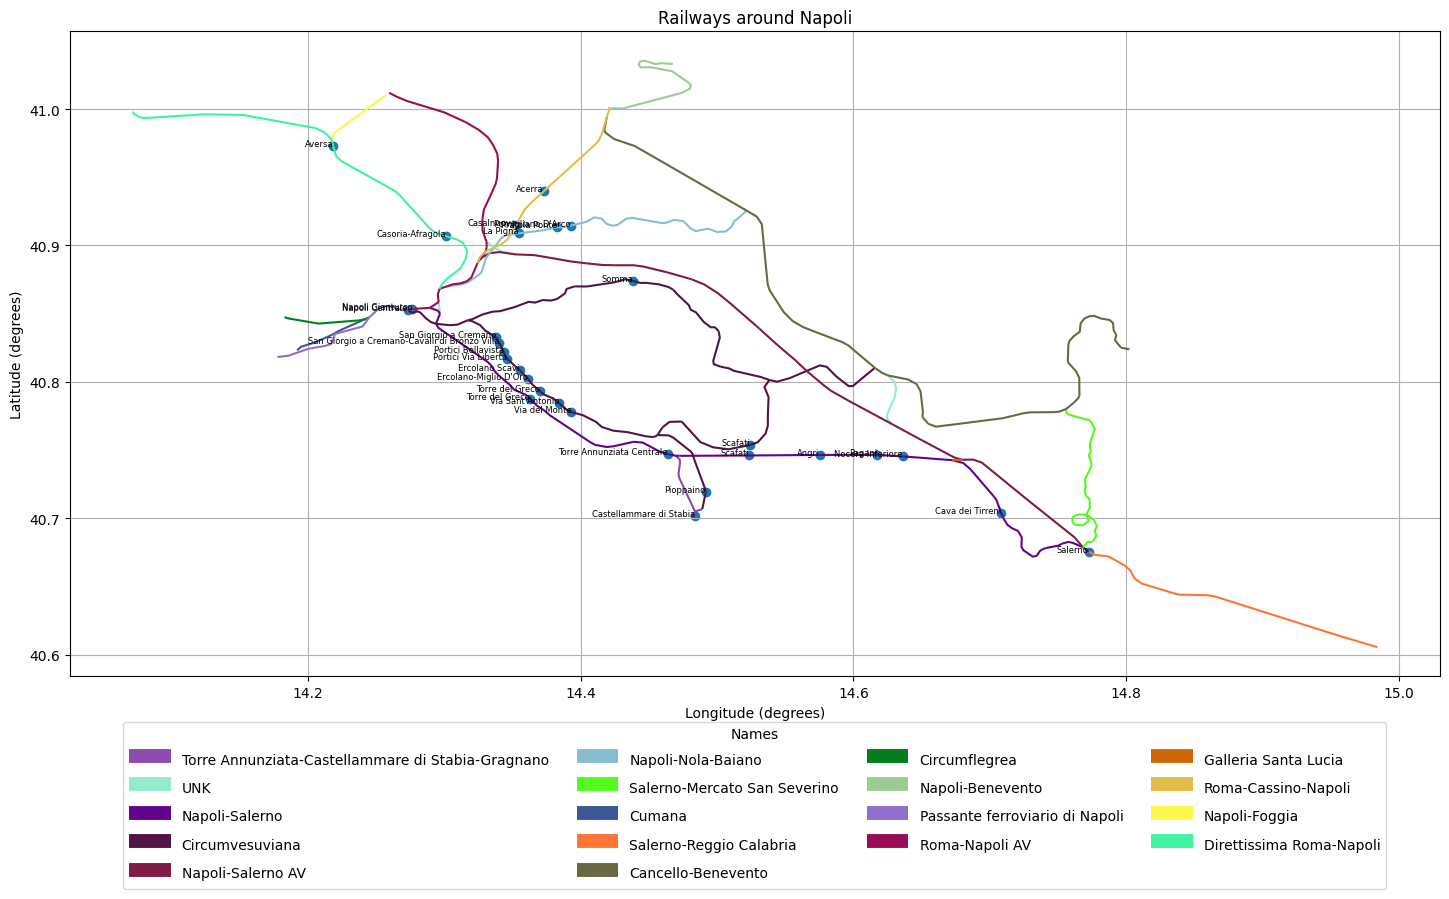

In [12]:
random_color_vec = [random_color() for i in np.arange(0, len(nomi_temp))]

fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(temp_stations['longitude'], temp_stations['latitude'], marker = "o")
for i, row in temp_stations.iterrows():
    ax.text(row['longitude'], row['latitude'], row['node_label'], fontsize=6, ha='right')

for i, name in enumerate(nomi_temp):
    df = combined_gdf[combined_gdf['NAMA1'] == name]
    df.plot(ax=ax, color = random_color_vec[i], linewidth = 1.5, label = name)

legend = ax.legend(title='Names', bbox_to_anchor=(0.5, -0.2), loc='center', ncol=4, handlelength=3, handleheight=2)
for line in legend.get_lines():
    line.set_linewidth(10)
plt.tight_layout(rect=[0, 0.1, 1, 1])

ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
# Make the grid denser by setting the ticks
#ax.set_xticks(np.arange(minimum_longitude, maximum_longitude, 0.05)) 
#ax.set_yticks(np.arange(minimum_latitude, maximum_latitude, 0.05)) 
# Enable the grid
ax.grid(which='both')
ax.set_title("Railways around Napoli")
plt.savefig("napoli_area.pdf", dpi = 300)
plt.show()

In [25]:
napoli_area = pd.DataFrame(columns=['rail_name', 'stops'])

data = []
for i, name in enumerate(nomi_temp):
    df = combined_gdf[combined_gdf['NAMA1'] == name]
    cities_temp = extract_stops(df, italy_stations) 
    data.append({'rail_name': name, 'stops': cities_temp})

napoli_area = pd.DataFrame(data)
napoli_area.to_csv('napoli_area.csv', index=False)

Ok, it works pretty fine, but there is still one issue that I think I cannot solve:
some stops are missing, because the data is not accurate. For example, the rail 'Roma-Cassino-Napoli' obviously ends in Napoli, but it connects to 
another rail a few km before actually entering Napoli, thus Napoli does not appear as a stop of 'Roma-Cassino-Napoli' but only as a stop of this other rail.

The only way to solve this problem would be to join together two rails which that have one endpoint and one start point that coincide.
But this in turn would create a much bigger problem, because then every city would result to be directly connected to every other city independently of the number of rail changes to make.

In my graph, I want a direct edge between A and B if and only if A and B are two stops belonging to the same rail.
This is a sufficient (but not necessary) condition to have a direct train trip between the two.
It could be that a direct trip exists between two cities in two different rails (like for example Padova and Termoli: first you
need to follow the 'Ancona-Lecce' rail and then the 'Ancona- Bologna' and then 'Bologna - Venezia', but still the trip is direct).
But I have no way to know it from this data: I don't know how companies operate on the rails, I only have the geographic, infrastructural information.



In summary, I cannot do better than this. Let's then proceed and apply the protocol to the whole EU

## Edges extraction

Firstly, I create for each country separately and for whole EU a .csv file named "ICC_rails.csv" with columns (railway_name, railway_stops_list).

Then, I create a file "ICC_edges.csv". Two cities will be connected by an edge iff they belong to the same railway_stops_list.

To conclude, I will filter out multiple edges.

NOTE: This block of code below takes 5 minutes to execute

Analyzing country =  IT
number of railway stations =  206
number of railways 310
first ten railway names=  ['Ancona-Lecce', 'Foggia-Manfredonia', 'Macomer-Nuoro', 'Chivasso-Ivrea-Aosta', 'Teramo-Giulianova', 'Chilivani-Olbia', 'Cagliari-Sassari', 'Aosta-Pont Saint Martin', 'Bologna-Verona', 'Messina-Palermo']


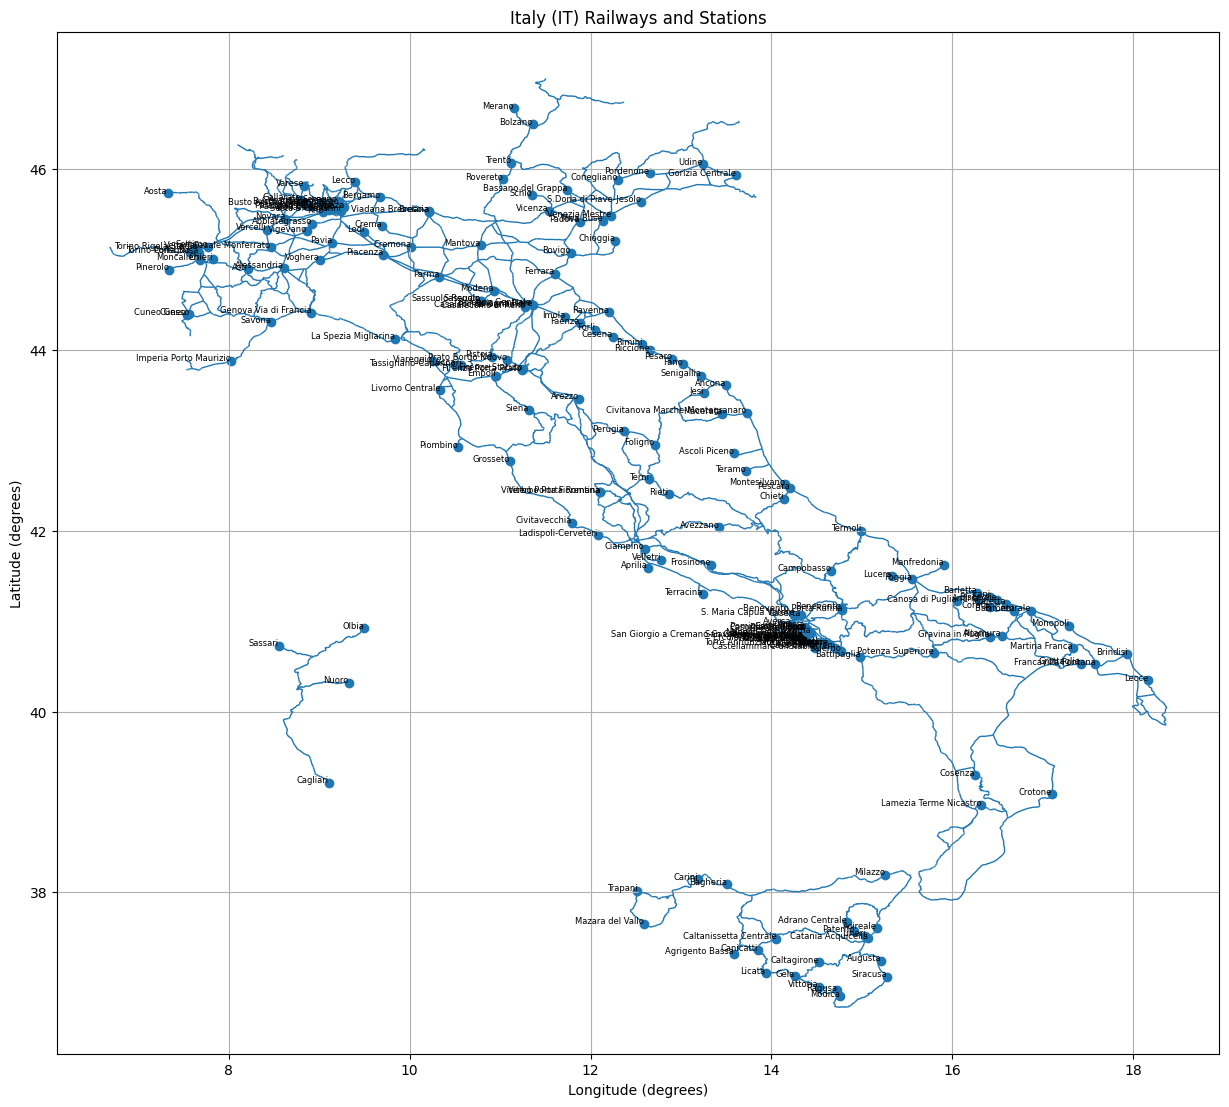

In [36]:
keys_list = sorted(list(ICC_labels.keys()))
start_index = keys_list.index('IT')
keys_sublist = keys_list[start_index:]


#for country_code in keys_sublist:
country_code = 'IT'
print("Analyzing country = ", country_code)

path = f"{country_code}_nodes.csv"
stations_temp = pd.read_csv(path)

rails_temp = rails[rails['ICC'] == country_code].copy()
print("number of railway stations = ", len(stations_temp))
names_temp = rails_temp['NAMA1'].unique()
names_temp_list = names_temp.tolist()
print("number of railways",len(names_temp_list))
print("first ten railway names= ", names_temp_list[0:10])

################## scatterplots ##########################
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

rails_temp.plot(ax=ax,  linewidth = 1)
ax.scatter(stations_temp['longitude'], stations_temp['latitude'], marker = "o")
for i, row in stations_temp.iterrows():
    ax.text(row['longitude'], row['latitude'], row['node_label'], fontsize=6, ha='right')
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")
ax.grid()
ax.set_title(f"{ICC_labels[country_code]} ({country_code}) Railways and Stations")

pdf_path = f"{country_code}_scatter.pdf"
plt.savefig(pdf_path, dpi = 300 )

################## edges extraction #####################
df_temp = pd.DataFrame(columns=['railway_name', 'railway_stops'])
data = []
for i, name in enumerate(names_temp):
    df_temp = rails_temp[rails_temp['NAMA1'] == name]
    cities_temp = extract_stops(df_temp, stations_temp) 
    data.append({'railway_name': name, 'railway_stops': cities_temp})
df_temp = pd.DataFrame(data)
df_temp.to_csv(f'{country_code}_rails.csv', index=False)
    

Final step: creation of edges file for each country 'ICC_edges.csv'. Some important notes:

- At first I considered creating a file with multiple edges allowed, one for each different railway that connects two nodes. But the PC cannot handle so much memory. Thus, I simply create the file of columns ['nodeID_from', 'nodeID_to', node_label_from', 'node_label_to']

- There are some places where more than one station exists (for example, Scafati locality in Naples' area has 2 different stations). I had to consider all stations for the correct identification of railway stops. But now I need to delete the duplicates from the final output files 'ICC_nodes.csv' and 'ICC_edges.csv', and re-assign the indices to the vertices starting from 1, otherwise igraph will not be able to create a graph object.

In [31]:
for country_code in keys_sublist:
    print("Finalizing nodes file for country = ", country_code)
    stations_file_path = f"{country_code}_nodes.csv"
    stations_temp = pd.read_csv(stations_file_path)
    ###################################################
    ### delete duplicate nodes and reassign indices ###
    ###################################################
    # check if duplicates present
    stations_names, counts = np.unique(stations_temp['node_label'], return_counts=True)
    if(any(i > 1 for i in counts)):
        print("duplicates found")
        for station_name, count in zip(stations_names, counts):
            if(count >1):
                indices = stations_temp.index[stations_temp['node_label'] == station_name][1:]
                stations_temp = stations_temp.drop(indices)
                stations_temp = stations_temp.reset_index(drop=True)
        new_index_list = np.arange(1, len(stations_temp) + 1)
        stations_temp = stations_temp.drop(columns= ['node_ID'])
        stations_temp.insert(0, 'node_ID', new_index_list)
        stations_temp.to_csv(f'{country_code}_nodes.csv', index=False)

Finalizing nodes file for country =  IT
Finalizing nodes file for country =  LT
Finalizing nodes file for country =  LU
Finalizing nodes file for country =  LV
Finalizing nodes file for country =  MD
Finalizing nodes file for country =  MK
Finalizing nodes file for country =  ND
Finalizing nodes file for country =  NL
Finalizing nodes file for country =  NO
Finalizing nodes file for country =  PL
Finalizing nodes file for country =  PT
Finalizing nodes file for country =  RO
Finalizing nodes file for country =  RS
Finalizing nodes file for country =  SE
Finalizing nodes file for country =  SI
Finalizing nodes file for country =  SK
Finalizing nodes file for country =  UA


In [30]:
#for country_code in keys_sublist:
country_code = 'IT'
print("Creating edge file for country = ", country_code)

rail_file_path = f'{country_code}_rails.csv'
rail_file_temp = pd.read_csv(rail_file_path)
# this is necessary to convert the column 'railway_stops' to a list of strings and then iterate over its elements
rail_file_temp['railway_stops'] = rail_file_temp['railway_stops'].apply(ast.literal_eval)

stations_file_path = f"{country_code}_nodes.csv"
stations_temp = pd.read_csv(stations_file_path)

edges_df_temp = pd.DataFrame(columns=['nodeID_from', 'nodeID_to', 'node_label_from', 'node_label_to'])
data = []

for i in np.arange(0, len(stations_temp)):
    for j in np.arange(i+1, len(stations_temp)):
        city_a = stations_temp['node_label'].iloc[i]
        city_b = stations_temp['node_label'].iloc[j]
        check_if_present = False
        for n, row in rail_file_temp.iterrows():
            temp_railway_name = row['railway_name']
            temp_stops_list = row['railway_stops']
            if( any(element == city_a for element in temp_stops_list) & any( element == city_b for element in temp_stops_list)):
                check_if_present = True
                data.append({'nodeID_from': i+1, 'nodeID_to': j+1, 'node_label_from' : city_a, 'node_label_to' : city_b})
                break

edges_df_temp = pd.DataFrame(data)
edges_df_temp.to_csv(f'{country_code}_edges.csv', index=False)

Creating edge file for country =  IT
